# [CSE426] Image Processing
Teaching Assistant: Hyunmin Ban (hmban1996@khu.ac.kr)

Professor: Hui Yong Kim (hykim.v@khu.ac.kr)

---

# P9: Image Restoration

## P9.A: Restoration by Inverse Filtering (6점)

### 실습내용
실습은 다음 순서로 진행됩니다.
- 0) 실습에서 사용되는 패키지 import
- 1) 주어진 이미지 loading
- 2) 함수 정의
- 3) Matplotlib로 이미지 확인

### 점수
- 각 함수 당 1점

### 제출방법
- .ipynb 파일과 함께 .html 파일 (File -> export (Download) as -> HTML)도 함께 제출하세요. 하나만 제출할시 감점이 있습니다.
- e-campus에 .ipynb 파일과 .html 파일을 zip파일로 하지 말고 따로따로 올리세요.

## Imports

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img

## 1) Load Image

In [2]:
img = cv2.imread('lena.tif', cv2.IMREAD_GRAYSCALE)

cv2.imshow('image', img)      
cv2.waitKey(0)                
cv2.destroyAllWindows()       

## 2) Define Function

**요구사항**

- 1) degradation_gaussian_blur과 gaussian_noise는 원본 이미지(f)를 degraded 된 이미지(g)로 만드는 함수로 수정하지 마세요.
- 2) degradation_gaussian_blur에서 degraded 된 이미지(g)와 Transfer function (H)가 반환되며 H는 Inverse filter와 Wiener filter에서 사용됩니다.
- 3) inverse filter를 구현하여 gaussian blur로만 degrade한 이미지를 복원하면 깨끗하게 나옵니다. ([1]의 결과) 
- 4) 하지만 gaussian noise가 들어가면 inverse filter의 결과가 잘 안 나옵니다. ([2]의 결과)
- 5) inverse filter의 결과 F_hat에 cutoff frequency를 주면 4)에서 문제가 되는 noise를 제거할 수 있습니다. ([3]의 결과)
- 6) Cutoff frequency는 이전 실습과제에서 구현한 Ideal Lowpass Filter를 사용하고 적절한 D_zero값을 찾아서 사용하세요. 

In [13]:
def degradation_gaussian_blur(f, size, std): 
    f_padded = np.pad(f, ((0, f.shape[0]), (0, f.shape[1])), 'reflect')
    F = np.fft.fftshift(np.fft.fft2(f_padded))
    
    # Gaussian Blur Transfer Function
    kernel = cv2.getGaussianKernel(size,std)
    h = np.outer(kernel, kernel.transpose())
    H = np.fft.fftshift(np.fft.fft2(h,s=f_padded.shape))
    G = F * H 
    
    g_padded = np.fft.ifft2(np.fft.ifftshift(G))
    g = g_padded[0:f.shape[0],0:f.shape[1]]
    blurred_img = np.clip(np.real(g), 0, 255)
    
    return blurred_img, H

def gaussian_noise(image, std):
    noisy_image = image + np.random.normal(0, std, image.shape)  
    return noisy_image.astype('uint8')

In [14]:
import numpy as np

def inverse_filter(g, H, cutoff=True, D_zero=0):
    g_padded = np.pad(g, ((0, g.shape[0]), (0, g.shape[1])), 'reflect')
    G = np.fft.fftshift(np.fft.fft2(g_padded))
    
    H_inverse = 1 / H
    
    if cutoff == True:
        N, M = G.shape
        fy, fx = np.linspace(0, N - 1, N), np.linspace(0, M - 1, M)
        u, v = np.meshgrid(fx, fy)
        D = np.sqrt((u - M / 2) ** 2 + (v - N / 2) ** 2)
        H_cutoff = (D <= D_zero).astype(float)
        H_inverse = H_inverse * H_cutoff
    
    F_hat = G * H_inverse
    
    f_hat_padded = np.fft.ifft2(np.fft.ifftshift(F_hat))
    f_hat = f_hat_padded[:g.shape[0], :g.shape[1]]
    result = np.clip(np.real(f_hat), 0, 255)
    
    return result.astype('uint8')


In [31]:
# [1]: g = 원본 이미지 + gaussian blur
blurred_img, H = degradation_gaussian_blur(img, 15, 1.2)
restored_blur_img = inverse_filter(blurred_img, H)

# [2]: g = 원본 이미지 + gaussian blur + gaussian noise
noisy_img = gaussian_noise(blurred_img, 2)
restored_noisy_img = inverse_filter(noisy_img, H)

# [3]: [2]의 g + Cutoff frequency 적용
# [3]: [2]의 g + Cutoff frequency 적용
restored_img_cutoff = inverse_filter(noisy_img, H, cutoff=True, D_zero=100)

## 3) Plot Image

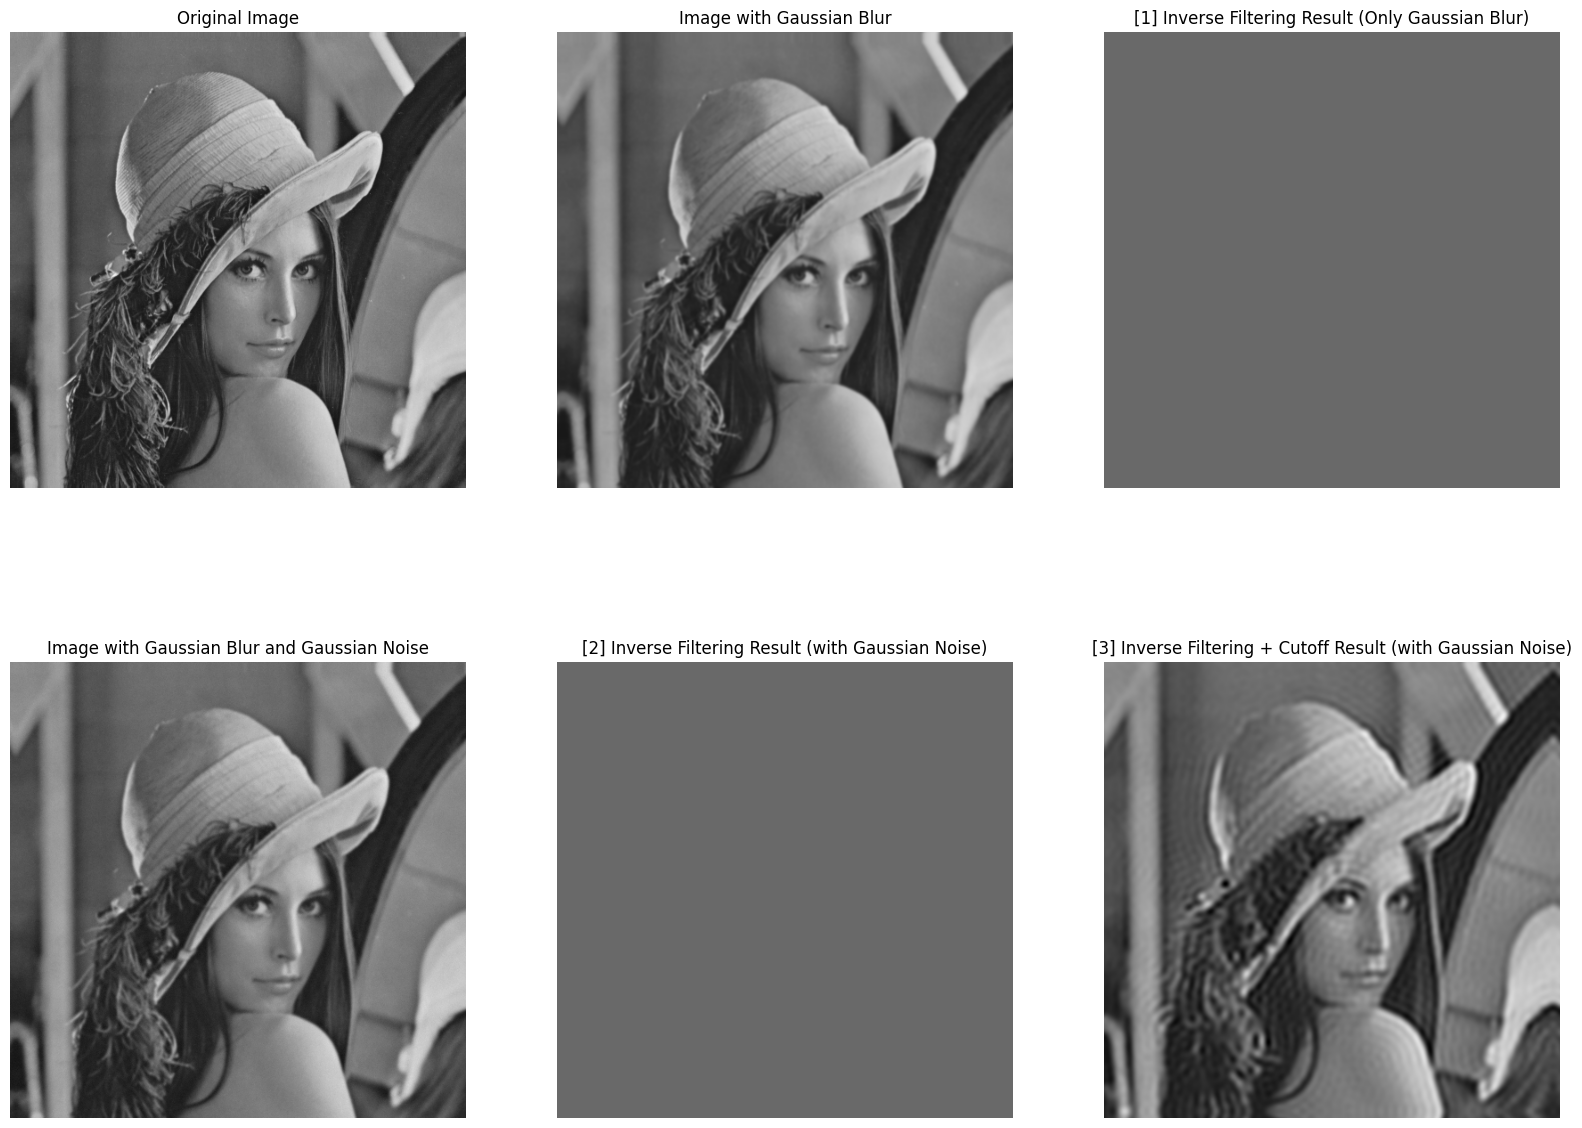

In [26]:
plt.figure(figsize = (20, 15))
images = {'Original Image':img, 'Image with Gaussian Blur':blurred_img.astype('uint8'), 
          '[1] Inverse Filtering Result (Only Gaussian Blur)':restored_blur_img,
          'Image with Gaussian Blur and Gaussian Noise':noisy_img, 
          '[2] Inverse Filtering Result (with Gaussian Noise)':restored_noisy_img,
          '[3] Inverse Filtering + Cutoff Result (with Gaussian Noise)':restored_img_cutoff,
         }

for i, (k, v) in enumerate(images.items()):
    plt.subplot(2,3,i+1)
    plt.title(k)
    plt.imshow(cv2.cvtColor(v, cv2.COLOR_GRAY2RGB))
    plt.axis("off")
    
plt.show()

---

## P9.B: Restoration by Wiener Filtering (4점)

### 실습내용
실습은 다음 순서로 진행됩니다.
- 1) 주어진 이미지 loading
- 2) 함수 정의
- 3) Matplotlib로 이미지 확인
- 4) Discussion

### 점수
- 각 함수 당 1점

### 제출방법
- .ipynb 파일과 함께 .html 파일 (File -> export (Download) as -> HTML)도 함께 제출하세요. 하나만 제출할시 감점이 있습니다.

## 1) Load Image

In [27]:
img = cv2.imread('lena.tif', cv2.IMREAD_GRAYSCALE)

cv2.imshow('image', img)      
cv2.waitKey(0)                
cv2.destroyAllWindows()   

## 2) Define Function

**요구사항**

- 1) P9.A에서 사용하는 degradation function을 그대로 사용하여 degraded 된 이미지 g를 생성합니다.
- 2) Wiener filter를 구현하고 가장 결과를 잘 낼 수 있는 K값을 설정하세요.
- 3) Inverse filter 또한 가장 결과를 잘 낼 수 있는 D_zero값을 구하고 Wiener filter과 비교하세요.

In [32]:
def wiener_filter(g, H, K):
    g_padded = np.pad(g, ((0, g.shape[0]), (0, g.shape[1])), 'reflect')
    G = np.fft.fft2(g_padded) # fourier transform 사용
    
    H_wiener = np.conj(H) / (np.abs(H) ** 2 + K) # Wiener filter 구현
    F_hat = G * H_wiener
    
    f_hat_padded = np.fft.ifft2(F_hat) # inverse fourier transform 사용
    f_hat = f_hat_padded[:g.shape[0], :g.shape[1]] # padding 했던 영역을 crop
    
    result = np.clip(np.real(f_hat), 0, 255)
    
    return result.astype('uint8'), F_hat

In [65]:
def wiener_filter(g, H, K, padding='zero'):
    if padding == 'zero':
        g_padded = np.pad(g, ((0, g.shape[0]), (0, g.shape[1])), 'constant')
    elif padding == 'reflect':
        g_padded = np.pad(g, ((0, g.shape[0]), (0, g.shape[1])), 'reflect')
    else:
        raise ValueError("Invalid padding method.")

    G = np.fft.fft2(g_padded)

    H_wiener = np.conj(H) / (np.abs(H) ** 2 + K)
    F_hat = G * H_wiener

    f_hat_padded = np.fft.ifft2(F_hat)
    f_hat = f_hat_padded[:g.shape[0], :g.shape[1]]

    result = np.clip(np.real(f_hat), 0, 255)

    return result.astype('uint8'), F_hat

K = 10

restored_img_zero, F_hat_zero = wiener_filter(noisy_img, H, K, padding='zero')
restored_img_reflect, F_hat_reflect = wiener_filter(noisy_img, H, K, padding='reflect')


In [66]:
blurred_img, H = degradation_gaussian_blur(img,15,1.8)
noisy_img = gaussian_noise(blurred_img, 4)

restored_img_wiener, F_hat = wiener_filter(noisy_img, H, 0.000065)
restored_img_inverse = inverse_filter(noisy_img, H, cutoff=True, D_zero=100)

## 3) Plot Image

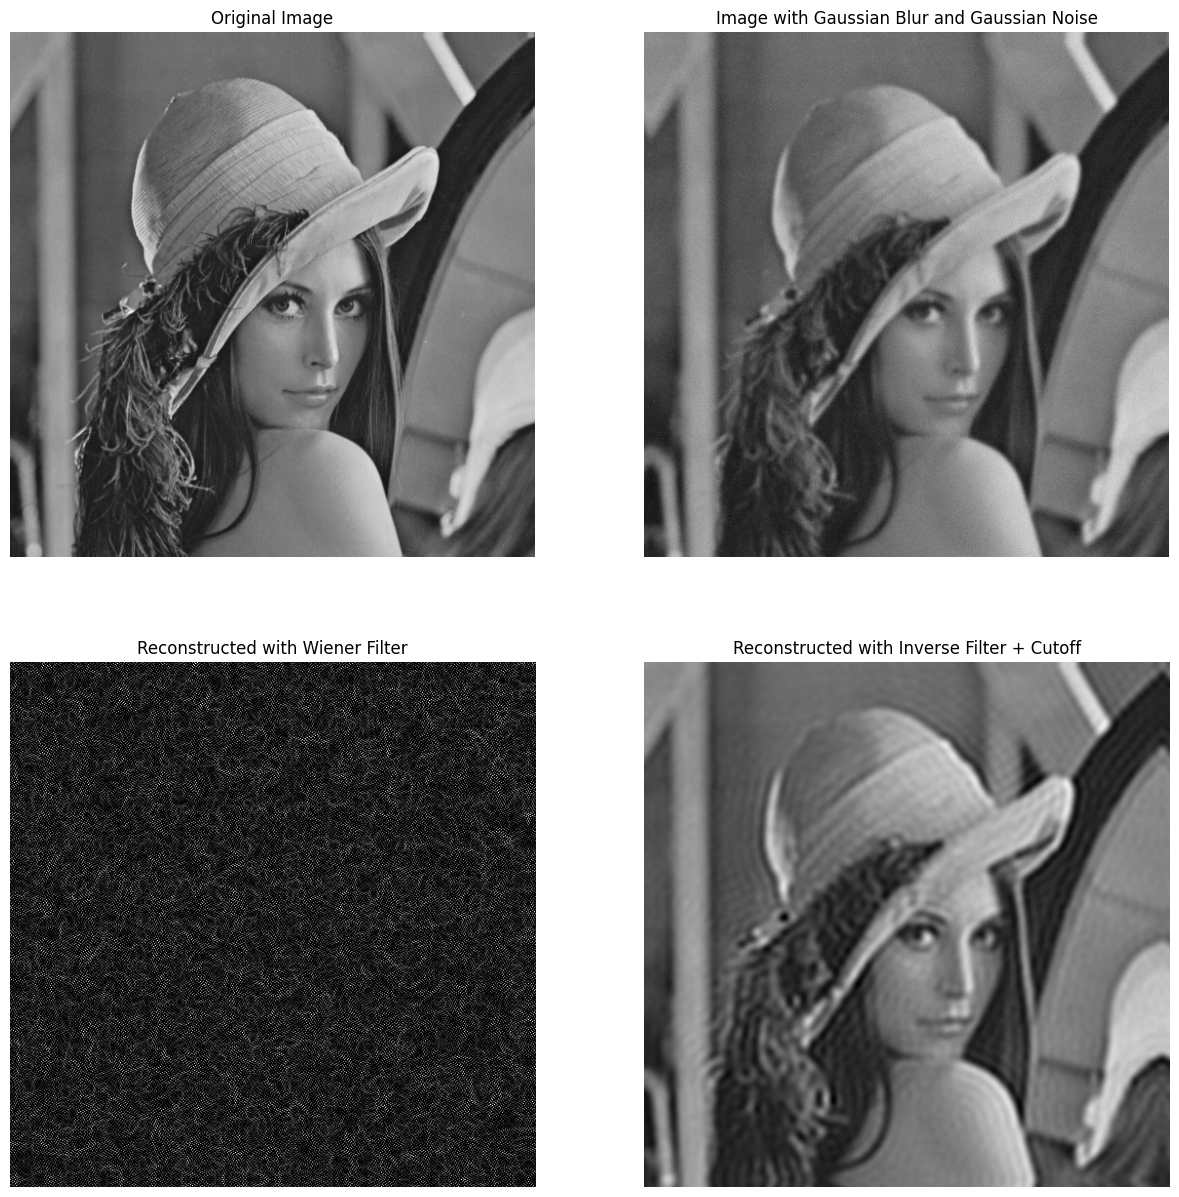

In [64]:
plt.figure(figsize = (15, 15))
images = {'Original Image':img, 'Image with Gaussian Blur and Gaussian Noise':noisy_img, 
          'Reconstructed with Wiener Filter':restored_img_wiener,
          'Reconstructed with Inverse Filter + Cutoff':restored_img_inverse, 
         }

for i, (k, v) in enumerate(images.items()):
    plt.subplot(2,2,i+1)
    plt.title(k)
    plt.imshow(cv2.cvtColor(v, cv2.COLOR_GRAY2RGB))
    plt.axis("off")
plt.show()

## 4) Discussion

**1) Inverse Filtering과 Wiener Filtering의 차이에 대해 설명하세요.**

1. inverse filtering
개요 : 복원하려는 이미지를 degradation 함수의 역함수를 사용하여 입력 이미지로 되돌린다.
장점 : 완벽한 복원이 가능하다.
단점 : 역함수를 추정하기 어렵거나, 노이즈가 있다면 완벽한 복원이 불가능하다.
2. wiener filtering
개요 : 입력 이미지와 degradation 함수를 모두 고려하여 입력 이미지로 되돌린다.
장점 : inverse filtering 보다 안정적이다.
단점 : 보정이 완벽하진 않으며, 매개변수를 찾아야 한다.

**2) Padding 방법을 zero padding으로 바꾸고 ‘reflect’방법과 결과를 가지고 비교 및 분석하세요.**

zero padding은 그림의 가장자리에 0이 추가되므로 영향을 준다.
하지만, reflect padding은 주변 정보를 참고하여 채우기에 입력 이미지와 비슷한 효과를 얻을 수 있다.
결과적으로, reflect padding에서 가장자리가 더 잘 보존된다.

**3) Constrained Least Square Filtering에 대해 설명하세요.**

constrained least square filtering은 푸리에 변환을 수행한 뒤, 이미지의 frequency domain에서 복원필터를 계산한다. 그 후 복원 필터와 입력이미지를 곱하고, 역푸리에 변환을 통해 이미지를 복원한다.

wiener filtering 보다 세밀하게 복원 결과를 제어할 수 있으며, 선명한 이미지를 얻을 수 있다.


---